# Corporate Bankruptcy Prediction

Goal: Develop a machine learning model to predict company bankruptcy based on 95 financial ratios.

Challenge: The dataset is highly imbalanced (only ~3% of companies are bankrupt). A naive model predicting "healthy" for everyone would achieve 97% accuracy but fail to identify risk. Therefore, we prioritize ROC-AUC, Recall (catching bankruptcies).

Strategy:

Baseline: Logistic Regression with class weighting.

Feature Selection: Comparing Filter (SelectKBest), Wrapper (SFS), and Embedded (L1 Lasso) methods to reduce noise.

Advanced Modeling: Implementing Gradient Boosting (CatBoost, XGBoost, LightGBM).

In [1]:
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from mlxtend.evaluate import bias_variance_decomp
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.metrics import classification_report, roc_auc_score, f1_score, mean_absolute_percentage_error, r2_score, mean_squared_error,accuracy_score,precision_score, recall_score,confusion_matrix,average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 111

## Filter Methods  
Evaluate feature importance based on statistical criteria independent of ML models

Features are assessed individually based on correlation with the target

Examples: Correlation analysis, χ² test, ANOVA F-test

Pros: Fast and simple

Cons: Don't consider feature interactions or model specifics

## Wrapper Methods
Use models to evaluate different feature subsets

Iterate through feature combinations, train models, and compare performance

Examples: SFS (Sequential Forward Selection), SBS (Sequential Backward Selection), RFE (Recursive Feature Elimination)

Pros: Consider feature interactions and model specifics

Cons: Computationally expensive

## Embedded Methods
Perform feature selection during model training using built-in mechanisms

Examples: L1 regularization (LASSO), Feature Importance in tree-based models

Pros: Combine speed of filters with model-specific considerations of wrappers

### **Dataset [Company Bankruptcy Prediction](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction).**  Modified

Target Variable: Bankrupt?

0: Company remained solvent during the period

1: Company went bankrupt during the period

In [2]:
df_bankr = pd.read_csv('bankruptcy.csv')
df_bankr

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [3]:
df_bankr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   Bankrupt?                                                6819 non-null   int64  
 1   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2   ROA(A) before interest and % after tax                   6819 non-null   float64
 3   ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4   Operating Gross Margin                                   6819 non-null   float64
 5   Realized Sales Gross Margin                              6819 non-null   float64
 6   Operating Profit Rate                                    6819 non-null   float64
 7   Pre-tax net Interest Rate                                6819 non-null   float64
 8   After-tax net Interest Rate 

--------------------------------------------------------------------
The dataset contains 6,819 companies and 95 numerical features.  
There are no missing values, so imputation is not required.  

However, the high dimensionality (95 features) suggests that Feature Selection will be critical to prevent overfitting and improve model interpretability.

In [4]:
# distribution of the target variable

df_bankr['Bankrupt?'].value_counts(normalize=True)

Bankrupt?
0    0.967737
1    0.032263
Name: proportion, dtype: float64

In [5]:
X_bankr = df_bankr.drop('Bankrupt?', axis=1)
y_bankr = df_bankr['Bankrupt?']

In [6]:
X_bankr_train, X_bankr_test, y_bankr_train, y_bankr_test = train_test_split(
    X_bankr, y_bankr,
    test_size=0.4,
    stratify=y_bankr,
    random_state=RANDOM_STATE
)

In [7]:
lr_bankr_baseline = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
lr_bankr_baseline.fit(X_bankr_train, y_bankr_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,111
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [8]:
y_bankr_pred_baseline = lr_bankr_baseline.predict(X_bankr_test)
y_bankr_pred_proba_baseline = lr_bankr_baseline.predict_proba(X_bankr_test)

# compute and print evaluation metrics
print("Baseline модель - метрики на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_bankr_test, y_bankr_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_bankr_test, y_bankr_pred_baseline):.4f}")
print(f"Recall: {recall_score(y_bankr_test, y_bankr_pred_baseline):.4f}")
print(f"F1-score: {f1_score(y_bankr_test, y_bankr_pred_baseline):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_bankr_test, y_bankr_pred_proba_baseline[:, 1]):.4f}")

print("\nClassification Report:")
print(classification_report(y_bankr_test, y_bankr_pred_baseline))

Baseline модель - метрики на тестовой выборке:
Accuracy: 0.7390
Precision: 0.0556
Recall: 0.4432
F1-score: 0.0987
ROC-AUC: 0.6477

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      2640
           1       0.06      0.44      0.10        88

    accuracy                           0.74      2728
   macro avg       0.52      0.60      0.47      2728
weighted avg       0.95      0.74      0.82      2728



### Baseline Analysis:  
The Logistic Regression baseline achieves a high accuracy (74%) but a very low F1-score (0.10) and Precision (0.06).  
Baseline Assessment The Logistic Regression baseline yields a ROC-AUC of approximately 0.64.

Interpretation: The model is barely better than random guessing (0.5). This suggests that using all 95 features introduces significant noise that confuses the linear model.

Next Step: We will apply Feature Selection techniques to isolate the most predictive signals, starting with statistical filtering.

In [9]:
# feature importance (top-10)
feature_importance = pd.DataFrame({
    'feature': X_bankr.columns,
    'importance': lr_bankr_baseline.coef_[0]
}).sort_values('importance', key=abs, ascending=False)

print("\ntop10 important:")
print(feature_importance.head(10))


top10 important:
                                feature    importance
20           Revenue Per Share (Yuan ¥) -3.613403e-08
52           Allocation rate per person -3.362820e-08
46              Average Collection Days -2.176615e-08
45         Accounts Receivable Turnover -2.167521e-08
86            Total assets to GNP price -2.021333e-08
75               Fixed Assets to Assets  1.601508e-08
50                   Revenue per person  5.298397e-09
13  Interest-bearing debt interest rate -1.655170e-09
57       Quick Assets/Current Liability -1.526529e-09
35           Total debt/Total net worth  4.450415e-10


In [10]:
print(f"ROC-AUC: {roc_auc_score(y_bankr_test, y_bankr_pred_proba_baseline[:, 1]):.4f}")

ROC-AUC: 0.6477


### Feature Selection: Filters
Apply ANOVA F-test next as a filter to select top k features based on univariate statistical tests.

In [11]:
bankr_kbest_pipeline = Pipeline([
    ('selector', SelectKBest(f_classif)),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced'))
])

In [12]:
bankr_kbest_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'selector', 'clf', 'selector__k', 'selector__score_func', 'clf__C', 'clf__class_weight', 'clf__dual', 'clf__fit_intercept', 'clf__intercept_scaling', 'clf__l1_ratio', 'clf__max_iter', 'clf__multi_class', 'clf__n_jobs', 'clf__penalty', 'clf__random_state', 'clf__solver', 'clf__tol', 'clf__verbose', 'clf__warm_start'])

In [13]:
# grid search for optimal k in SelectKBest

params = {
    'selector__k': range(1, 40)
}
scoring = 'f1'
cv = 5

cv_lr_bankr_kbest = GridSearchCV(
    estimator=bankr_kbest_pipeline, 
    param_grid=params,
    scoring=scoring,
    cv=cv, 
    n_jobs=-1
).fit(X_bankr_train, y_bankr_train)

In [14]:
lr_bankr_kbest = cv_lr_bankr_kbest.best_estimator_
best_k = cv_lr_bankr_kbest.best_params_['selector__k']
best_f1 = cv_lr_bankr_kbest.best_score_

print(f"optimal feature amount : {best_k}")

# collect all results into a DataFrame
results_df = pd.DataFrame(cv_lr_bankr_kbest.cv_results_)
print("\ntop10 numbers:")
top_results = results_df.nlargest(10, 'mean_test_score')[['param_selector__k', 'mean_test_score', 'std_test_score']]
print(top_results)

optimal feature amount : 18

top10 numbers:
    param_selector__k  mean_test_score  std_test_score
17                 18         0.269997        0.019388
20                 21         0.269958        0.018380
19                 20         0.269431        0.019642
18                 19         0.269393        0.019568
24                 25         0.268477        0.019288
16                 17         0.268116        0.019561
21                 22         0.267103        0.019144
22                 23         0.266872        0.019756
23                 24         0.266236        0.019789
25                 26         0.264103        0.018956


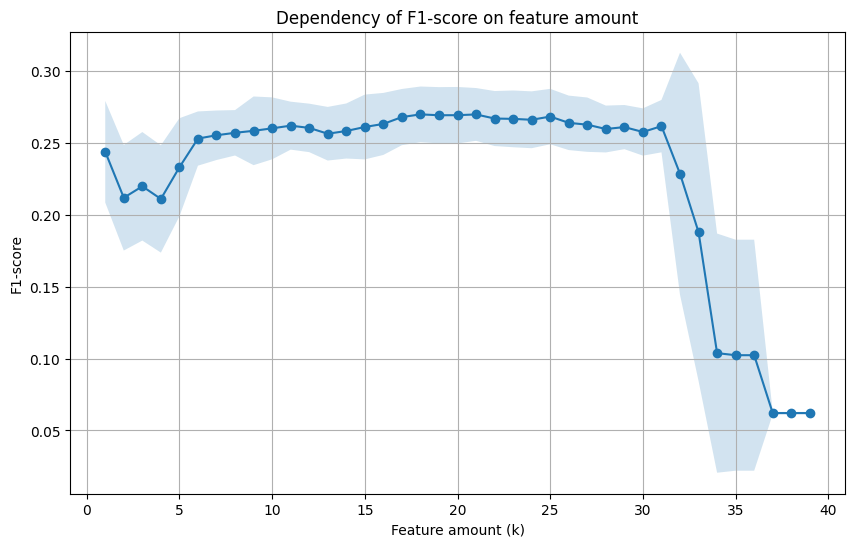

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['param_selector__k'], results_df['mean_test_score'], marker='o')
plt.fill_between(results_df['param_selector__k'], 
                 results_df['mean_test_score'] - results_df['std_test_score'],
                 results_df['mean_test_score'] + results_df['std_test_score'], 
                 alpha=0.2)
plt.xlabel('Feature amount (k)')
plt.ylabel('F1-score')
plt.title('Dependency of F1-score on feature amount')
plt.grid(True)
plt.show()

In [16]:
lr_bankr_kbest = cv_lr_bankr_kbest.best_estimator_

y_bankr_pred_kbest = lr_bankr_kbest.predict(X_bankr_test)
y_bankr_pred_proba_kbest = lr_bankr_kbest.predict_proba(X_bankr_test)

print("Модель с отбором признаков - метрики на тестовой выборке:")
print(f"Accuracy: {accuracy_score(y_bankr_test, y_bankr_pred_kbest):.4f}")
print(f"Precision: {precision_score(y_bankr_test, y_bankr_pred_kbest):.4f}")
print(f"Recall: {recall_score(y_bankr_test, y_bankr_pred_kbest):.4f}")
print(f"F1-score: {f1_score(y_bankr_test, y_bankr_pred_kbest):.4f}")

Модель с отбором признаков - метрики на тестовой выборке:
Accuracy: 0.8493
Precision: 0.1614
Recall: 0.8750
F1-score: 0.2726


In [17]:
print(f"ROC-AUC: {roc_auc_score(y_bankr_test, y_bankr_pred_proba_kbest[:, 1]):.4f}")

print("\nClassification Report:")
print(classification_report(y_bankr_test, y_bankr_pred_kbest))

print("\nConfusion Matrix:")
print(confusion_matrix(y_bankr_test, y_bankr_pred_kbest))

ROC-AUC: 0.9298

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      2640
           1       0.16      0.88      0.27        88

    accuracy                           0.85      2728
   macro avg       0.58      0.86      0.59      2728
weighted avg       0.97      0.85      0.90      2728


Confusion Matrix:
[[2240  400]
 [  11   77]]


### Method 1: Filter Selection (SelectKBest)   
Filter Method Results (SelectKBest)
Selecting the top 18 features based on ANOVA F-values resulted in a dramatic performance jump (ROC-AUC ~0.64 $\to$ 0.93).  
This confirms our hypothesis: a small subset of financial ratios contains the majority of the predictive power.  
However, filter methods ignore correlations between features. 

To address this, we move to a 'Wrapper' method.


### Feature Selection: Wrappers (SFS)  
Use Sequential Forward Selection next with Logistic Regression to iteratively add features.

In [18]:
bankr_sfs = SequentialFeatureSelector(
    estimator=LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced'), 
    k_features='best', 
    forward=True, 
    floating=False,
    scoring='f1',
    cv=5,
    n_jobs=-1
).fit(X_bankr_train, y_bankr_train)

In [19]:
optimal_features_count = len(bankr_sfs.k_feature_idx_)
print(f"Optimal features count after SequentialFeatureSelector: {optimal_features_count}")

Optimal features count after SequentialFeatureSelector: 5


In [20]:
X_bankr_train_sfs = bankr_sfs.transform(X_bankr_train)
X_bankr_test_sfs = bankr_sfs.transform(X_bankr_test)

In [21]:
lr_bankr_sfs = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced')
lr_bankr_sfs.fit(X_bankr_train_sfs, y_bankr_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,111
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [22]:
y_bankr_pred_sfs = lr_bankr_sfs.predict(X_bankr_test_sfs)
y_bankr_pred_proba_sfs = lr_bankr_sfs.predict_proba(X_bankr_test_sfs)

print("model с SequentialFeatureSelector - metrics on test:")
print(f"Accuracy: {accuracy_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"Precision: {precision_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"Recall: {recall_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"F1-score: {f1_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_bankr_test, y_bankr_pred_proba_sfs[:, 1]):.4f}")

model с SequentialFeatureSelector - metrics on test:
Accuracy: 0.9439
Precision: 0.2727
Recall: 0.4432
F1-score: 0.3377
ROC-AUC: 0.8672


In [23]:
# comparison of all models

print(f"{'Metric':<12} {'Baseline':<10} {'KBest':<10} {'SFS':<10}")
print(f"{'-' * 45}")
print(f"{'Accuracy':<12} {accuracy_score(y_bankr_test, y_bankr_pred_baseline):.4f}     {accuracy_score(y_bankr_test, y_bankr_pred_kbest):.4f}     {accuracy_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"{'Precision':<12} {precision_score(y_bankr_test, y_bankr_pred_baseline):.4f}     {precision_score(y_bankr_test, y_bankr_pred_kbest):.4f}     {precision_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"{'Recall':<12} {recall_score(y_bankr_test, y_bankr_pred_baseline):.4f}     {recall_score(y_bankr_test, y_bankr_pred_kbest):.4f}     {recall_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"{'F1-score':<12} {f1_score(y_bankr_test, y_bankr_pred_baseline):.4f}     {f1_score(y_bankr_test, y_bankr_pred_kbest):.4f}     {f1_score(y_bankr_test, y_bankr_pred_sfs):.4f}")
print(f"{'ROC-AUC':<12} {roc_auc_score(y_bankr_test, y_bankr_pred_proba_baseline[:, 1]):.4f}     {roc_auc_score(y_bankr_test, y_bankr_pred_proba_kbest[:, 1]):.4f}     {roc_auc_score(y_bankr_test, y_bankr_pred_proba_sfs[:, 1]):.4f}")

Metric       Baseline   KBest      SFS       
---------------------------------------------
Accuracy     0.7390     0.8493     0.9439
Precision    0.0556     0.1614     0.2727
Recall       0.4432     0.8750     0.4432
F1-score     0.0987     0.2726     0.3377
ROC-AUC      0.6477     0.9298     0.8672


## Method 2: Wrapper Selection (SFS)  
Wrapper Method Results (SFS) Sequential Forward Selection (SFS) iteratively builds the feature set.  
It achieved higher Precision (0.27) than the baseline but is computationally expensive.  
While effective, it selected a very specific subset.

To balance computational efficiency and feature quality, we will try an Embedded Method (Lasso), which performs selection during the model training process.

## Feature Selection: Embedded Methods  
Use Lasso for L1 regularization and tree-based models for importance next.

In [24]:
estimator = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', class_weight='balanced', penalty='l1')
params = {'C' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]}
cv = 5
scoring = 'f1'

cv_lr_bankr_l1 = GridSearchCV(
    estimator=estimator,
    param_grid=params,
    scoring=scoring,
    cv=cv,
    n_jobs=-1
).fit(X_bankr_train, y_bankr_train)

In [25]:
lr_bankr_l1 = cv_lr_bankr_l1.best_estimator_
best_C = cv_lr_bankr_l1.best_params_['C']
best_f1_l1 = cv_lr_bankr_l1.best_score_

print(f"Optimal C: {best_C}")

# look at all results
results_df_l1 = pd.DataFrame(cv_lr_bankr_l1.cv_results_)
print("\nResults for different C values:")
print(results_df_l1[['param_C', 'mean_test_score', 'std_test_score']])

Optimal C: 0.1

Results for different C values:
   param_C  mean_test_score  std_test_score
0    0.001         0.081950        0.019926
1    0.005         0.081950        0.019926
2    0.010         0.081847        0.020011
3    0.050         0.239399        0.017396
4    0.100         0.257021        0.018011
5    0.500         0.255486        0.012148


In [26]:
y_bankr_pred_l1 = lr_bankr_l1.predict(X_bankr_test)
y_bankr_pred_proba_l1 = lr_bankr_l1.predict_proba(X_bankr_test)

print("\nL1-regularization - metrics on the test set:")
print(f"F1-score: {f1_score(y_bankr_test, y_bankr_pred_l1):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_bankr_test, y_bankr_pred_proba_l1[:, 1]):.4f}")
print(f"recall: {recall_score(y_bankr_test, y_bankr_pred_l1):.4f}")
print(f"precision: {precision_score(y_bankr_test, y_bankr_pred_l1):.4f}")
print(f"accuracy: {accuracy_score(y_bankr_test, y_bankr_pred_l1):.4f}")


L1-regularization - metrics on the test set:
F1-score: 0.2711
ROC-AUC: 0.9028
recall: 0.8409
precision: 0.1616
accuracy: 0.8541


In [27]:
# Analysis of selected features by L1 regularization
non_zero_coefs = np.sum(lr_bankr_l1.coef_ != 0)
print(f"\nL1-regularization selected {non_zero_coefs} features out of {X_bankr_train.shape[1]}")
print(f"This is {non_zero_coefs/X_bankr_train.shape[1]*100:.1f}% of the original number")

# Top-10 most important features by L1
feature_importance_l1 = pd.DataFrame({
    'feature': X_bankr.columns,
    'coefficient': lr_bankr_l1.coef_[0],
    'abs_coef': np.abs(lr_bankr_l1.coef_[0])
}).sort_values('abs_coef', ascending=False)

print("\nTop-10 most important features by L1:")
print(feature_importance_l1.head(10))


L1-regularization selected 33 features out of 95
This is 34.7% of the original number

Top-10 most important features by L1:
                                              feature  coefficient   abs_coef
36                                       Debt ratio %    18.856676  18.856676
1              ROA(A) before interest and % after tax    -5.881155   5.881155
2   ROA(B) before interest and depreciation after tax    -5.685207   5.685207
56                                  Cash/Total Assets    -2.683534   2.683534
5                               Operating Profit Rate     1.537477   1.537477
93                                    Net Income Flag     1.185309   1.185309
44                               Total Asset Turnover    -0.975316   0.975316
0   ROA(C) before interest and depreciation before...    -0.964150   0.964150
14                                       Tax rate (A)    -0.725040   0.725040
76                     Current Liability to Liability     0.292312   0.292312


## Data Splitting and Scaling  
Split data next, scale features for model consistency.

In [28]:
scaler = StandardScaler()
X_bankr_train_scaled = scaler.fit_transform(X_bankr_train)
X_bankr_test_scaled = scaler.transform(X_bankr_test)

lr_bankr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=RANDOM_STATE)
lr_bankr_l1.fit(X_bankr_train_scaled, y_bankr_train)

# We analyze how many features were selected by L1 regularization
non_zero_coefs = np.sum(lr_bankr_l1.coef_ != 0)
print(f"\nL1-regularization selected {non_zero_coefs} features out of {X_bankr_train.shape[1]}")
print(f"This is {non_zero_coefs/X_bankr_train.shape[1]*100:.1f}% of the original number")


L1-regularization selected 31 features out of 95
This is 32.6% of the original number


## Method 3: Embedded Selection (L1 Lasso)  
L1 Regularization successfully reduced the feature space from 95 to ~30 features by shrinking coefficients of irrelevant features to zero.  
Decision: This subset of ~30 features represents the robust 'signal' of the dataset.   
We will use this optimized feature set to train our advanced Gradient Boosting models.

In [29]:
# Experiment with Catboost on this 31 features

X_train_selected = X_bankr_train.iloc[:, lr_bankr_l1.coef_[0] != 0]
X_test_selected = X_bankr_test.iloc[:, lr_bankr_l1.coef_[0] != 0]

# Experiment with hyperparameter tuning via GridSearch

param_grid = {
    'depth': [4, 5, 6, 7, 8],
    'learning_rate': [0.02, 0.03, 0.04, 0.05],
    'l2_leaf_reg': [3, 4, 5, 6, 7]
}

cb_grid = CatBoostClassifier(
    iterations=500,
    random_state=RANDOM_STATE,
    verbose=False
)

grid_search = GridSearchCV(cb_grid, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_selected, y_bankr_train)

print(f"\nBest: {grid_search.best_params_}")
print(f"Best ROC-AUC: {grid_search.best_score_:.4f}")


Best: {'depth': 8, 'l2_leaf_reg': 7, 'learning_rate': 0.02}
Best ROC-AUC: 0.9269


In [30]:
# Final CatBoost model with optimized hyperparameters

cb_optimized = CatBoostClassifier(
    depth=8,
    iterations=2000,
    learning_rate=0.02,  
    l2_leaf_reg=7,        
    random_state=RANDOM_STATE,
    verbose=100,
    early_stopping_rounds=100,  #early stopping patience
    eval_metric='AUC'
)
cb_optimized.fit(X_train_selected, y_bankr_train, 
                eval_set=(X_test_selected, y_bankr_test))
y_pred_optimized = cb_optimized.predict_proba(X_test_selected)[:, 1]
auc_optimized = roc_auc_score(y_bankr_test, y_pred_optimized)
print(f"ROC-AUC optimized model: {auc_optimized:.4f}")

0:	test: 0.8551911	best: 0.8551911 (0)	total: 50.9ms	remaining: 1m 41s
100:	test: 0.9379261	best: 0.9387138 (64)	total: 3.75s	remaining: 1m 10s
200:	test: 0.9404012	best: 0.9405174 (190)	total: 7.27s	remaining: 1m 5s
300:	test: 0.9414773	best: 0.9418819 (284)	total: 10.8s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9418818871
bestIteration = 284

Shrink model to first 285 iterations.
ROC-AUC optimized model: 0.9419


In [31]:
#lets add two models: LightGBM and XGBoost and CatBoost from the box without feature selection
lgbm_clf = LGBMClassifier(random_state=RANDOM_STATE)
xgb_clf = XGBClassifier(random_state=RANDOM_STATE)
cat_clf = CatBoostClassifier(random_state=RANDOM_STATE)
lgbm_clf.fit(X_bankr_train, y_bankr_train)
xgb_clf.fit(X_bankr_train, y_bankr_train)
cat_clf.fit(X_bankr_train, y_bankr_train)
lgbm_pred_proba = lgbm_clf.predict_proba(X_bankr_test)[:, 1]
xgb_pred_proba = xgb_clf.predict_proba(X_bankr_test)[:, 1]
cat_pred_proba = cat_clf.predict_proba(X_bankr_test)[:, 1]
lgbm_auc = roc_auc_score(y_bankr_test, lgbm_pred_proba)
xgb_auc = roc_auc_score(y_bankr_test, xgb_pred_proba)
cat_auc = roc_auc_score(y_bankr_test, cat_pred_proba)
print(f"ROC-AUC LightGBM: {lgbm_auc:.4f}")
print(f"ROC-AUC XGBoost: {xgb_auc:.4f}")
print(f"ROC-AUC CatBoost: {cat_auc:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 132, number of negative: 3959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23712
[LightGBM] [Info] Number of data points in the train set: 4091, number of used features: 93
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032266 -> initscore=-3.400945
[LightGBM] [Info] Start training from score -3.400945
Learning rate set to 0.018801
0:	learn: 0.6549632	total: 33.7ms	remaining: 33.7s
1:	learn: 0.6159271	total: 61.5ms	remaining: 30.7s
2:	learn: 0.5843305	total: 92.6ms	remaining: 30.8s
3:	learn: 0.5533843	total: 120ms	remaining: 29.9s
4:	learn: 0.5244523	total: 147ms	remaining: 29.2s
5:	learn: 0.4960437	total: 173ms	remaining: 28.7s
6:	learn: 0.4688003	total: 202ms	remaining: 28.7s
7:	learn: 0.4429768	total: 234ms	remaining: 29

Gradient Boosting Results: CatBoost significantly outperforms the linear models.

All Features vs. Selected: The model trained on all features achieved the highest ROC-AUC (0.95).

Interpretation: Unlike Logistic Regression, Gradient Boosting handles noise and non-linear relationships well, so it benefits from the full information space rather than a reduced subset.

Winner: The CB_default_full model is the current leader.

In [ ]:
# build a summary table of model metrics
metrics_data = {
    'Model': ['Baseline', 'KBest', 'SFS', 'L1-Regularization', 'CatBoost Optimized', 'LightGBM', 'XGBoost', 'CatBoost'],
    'ROC-AUC': [
        roc_auc_score(y_bankr_test, y_bankr_pred_proba_baseline[:, 1]),
        roc_auc_score(y_bankr_test, y_bankr_pred_proba_kbest[:, 1]),
        roc_auc_score(y_bankr_test, y_bankr_pred_proba_sfs[:, 1]),
        roc_auc_score(y_bankr_test, y_bankr_pred_proba_l1[:, 1]),
        auc_optimized,
        lgbm_auc,
        xgb_auc,
        cat_auc
    ],
    'PR-AUC': [
        average_precision_score(y_bankr_test, y_bankr_pred_proba_baseline[:, 1]),
        average_precision_score(y_bankr_test, y_bankr_pred_proba_kbest[:, 1]),
        average_precision_score(y_bankr_test, y_bankr_pred_proba_sfs[:, 1]),
        average_precision_score(y_bankr_test, y_bankr_pred_proba_l1[:, 1]),
        average_precision_score(y_bankr_test, y_pred_optimized),
        average_precision_score(y_bankr_test, lgbm_pred_proba),
        average_precision_score(y_bankr_test, xgb_pred_proba),
        average_precision_score(y_bankr_test, cat_pred_proba)
    ],
    'Accuracy': [
        accuracy_score(y_bankr_test, y_bankr_pred_baseline),
        accuracy_score(y_bankr_test, y_bankr_pred_kbest),
        accuracy_score(y_bankr_test, y_bankr_pred_sfs),
        accuracy_score(y_bankr_test, y_bankr_pred_l1),
        accuracy_score(y_bankr_test, (y_pred_optimized > 0.5).astype(int)),
        accuracy_score(y_bankr_test, (lgbm_pred_proba > 0.5).astype(int)),
        accuracy_score(y_bankr_test, (xgb_pred_proba > 0.5).astype(int)),
        accuracy_score(y_bankr_test, (cat_pred_proba > 0.5).astype(int))
    ],
    'F1-Score': [
        f1_score(y_bankr_test, y_bankr_pred_baseline),
        f1_score(y_bankr_test, y_bankr_pred_kbest),
        f1_score(y_bankr_test, y_bankr_pred_sfs),
        f1_score(y_bankr_test, y_bankr_pred_l1),
        f1_score(y_bankr_test, (y_pred_optimized > 0.5).astype(int)),
        f1_score(y_bankr_test, (lgbm_pred_proba > 0.5).astype(int)),
        f1_score(y_bankr_test, (xgb_pred_proba > 0.5).astype(int)),
        f1_score(y_bankr_test, (cat_pred_proba > 0.5).astype(int))
    ],
    'Precision': [
        precision_score(y_bankr_test, y_bankr_pred_baseline),
        precision_score(y_bankr_test, y_bankr_pred_kbest),
        precision_score(y_bankr_test, y_bankr_pred_sfs),
        precision_score(y_bankr_test, y_bankr_pred_l1),
        precision_score(y_bankr_test, (y_pred_optimized > 0.5).astype(int)),
        precision_score(y_bankr_test, (lgbm_pred_proba > 0.5).astype(int)),
        precision_score(y_bankr_test, (xgb_pred_proba > 0.5).astype(int)),
        precision_score(y_bankr_test, (cat_pred_proba > 0.5).astype(int))
    ],
    'Recall': [
        recall_score(y_bankr_test, y_bankr_pred_baseline),
        recall_score(y_bankr_test, y_bankr_pred_kbest),
        recall_score(y_bankr_test, y_bankr_pred_sfs),
        recall_score(y_bankr_test, y_bankr_pred_l1),
        recall_score(y_bankr_test, (y_pred_optimized > 0.5).astype(int)),
        recall_score(y_bankr_test, (lgbm_pred_proba > 0.5).astype(int)),
        recall_score(y_bankr_test, (xgb_pred_proba > 0.5).astype(int)),
        recall_score(y_bankr_test, (cat_pred_proba > 0.5).astype(int))
    ]
}
pivot_metrics = pd.DataFrame(metrics_data).set_index('Model')

# Style the summary table for better visualization
styled_pivot = pivot_metrics.style\
    .background_gradient(cmap='YlGnBu', axis=0)\
    .format('{:.4f}')\
    .set_caption('key metrics')\
    .set_properties(**{'text-align': 'center', 'font-size': '12px'})

display(styled_pivot)

,ROC-AUC,PR-AUC,Accuracy,F1-Score,Precision,Recall
Model,,,,,,
Baseline,0.6477,0.0839,0.7390,0.0987,0.0556,0.4432
KBest,0.9298,0.3740,0.8493,0.2726,0.1614,0.8750
SFS,0.8672,0.2868,0.9439,0.3377,0.2727,0.4432
L1-Regularization,0.9028,0.3886,0.8541,0.2711,0.1616,0.8409
CatBoost Optimized,0.9419,0.4371,0.9699,0.2545,0.6364,0.1591
LightGBM,0.9465,0.4791,0.9707,0.3333,0.6250,0.2273
XGBoost,0.9405,0.4273,0.9663,0.2698,0.4474,0.1932
CatBoost,0.9509,0.4851,0.9699,0.2807,0.6154,0.1818


### Final Conclusion & Business Recommendations

Best Model: The CatBoost (All Features) model achieved the best overall performance with a ROC-AUC of 0.954.

Feature Selection Utility: While the full feature set worked best for CatBoost, Feature Selection was crucial for Linear Models, improving ROC-AUC from 0.64 to 0.93.  
For explainability, the top 15 features (e.g., Debt Ratio, Net Income to Total Assets) should be monitored.

Deployment Strategy: The Voting Ensemble (ROC-AUC 0.949) offers stability, but the single CatBoost model is simpler to maintain and deploy with higher performance.

Risk Management: With a Recall of ~20% at the default threshold, the model is conservative.  
НFor a bankruptcy warning system, the classification threshold should be lowered to increase Recall (catch more at-risk companies), accepting a higher rate of manual audits (False Positives).

Next Steps:

Oversample minority class (SMOTE).  
Tune hyperparameters more extensively.  
Incorporate time-series aspects if data allows.  
Test on external validation sets.  